<a href="https://colab.research.google.com/github/sacontreras/dsc-mod-4-project-v2-1-online-ds-sp-000/blob/master/mod4-project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print(f'Device: {tpu.master()}')
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print(f'Number of replicas: {strategy.num_replicas_in_sync}')
    
print(f"Using Tensorflow verion {tf.__version__}")

Number of replicas: 1
Using Tensorflow verion 2.3.0


In [2]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

INPUT_SHAPE = (150,150)

BATCH_SIZE = 16 * strategy.num_replicas_in_sync

TRAINING_AUGMENTATION_RATIO = 0.25 # Must be >= 0 AND < 1; do note that the closer to 1 this is the more artificial data is used... take care to not overfit to augmented images
TRAINING_AUGMENTATION_FORCE_OVERWRITE = False

VALIDATION_SPLIT = 0.10

INITIAL_LEARNING_RATE = 0.001

from tensorflow.keras.optimizers import RMSprop, Adam, Nadam, Adamax
# OPTIMIZER = RMSprop(learning_rate=INITIAL_LEARNING_RATE)
OPTIMIZER = Adam(learning_rate=INITIAL_LEARNING_RATE)
# OPTIMIZER = Nadam(learning_rate=INITIAL_LEARNING_RATE)
# OPTIMIZER = Adamax(learning_rate=INITIAL_LEARNING_RATE)

LR_DECELERATION = 0.8
ACCURACY_THRESHOLD = 0.97

EPOCHS = 40

# Download images if we haven't already...

In [3]:
import tensorflow as tf
import urllib
import urllib.request
from tqdm.auto import tqdm
import numpy as np
import os
import zipfile

def download(url, local_fname, block_sz=8192):
  http_file = urllib.request.urlopen(url)
  if http_file.getcode() != 200:
      raise ValueError(f"ERROR {http_file.getcode()} while opening {url}.")

  meta = http_file.info()
  file_size = int(meta['Content-Length'])
  print(f"Downloading {url} (filesize: {file_size} bytes) to {local_fname}...")
  print()

  f = None
  try:
    f = open(local_fname, 'wb')
    file_size_dl = 0
    fblocks = np.arange(start=0, stop=file_size+1, step=block_sz)
    tqdm_pb = tqdm(fblocks)
    for tfblock in tqdm_pb: 
        buffer = http_file.read(block_sz)
        if not buffer:
            break
        file_size_dl += len(buffer)
        f.write(buffer)
  finally:
    if f is not None:
      f.close()

  file_size_local = os.path.getsize(f.name)
  if file_size_local != file_size:
      raise ValueError(f"URL file {url} is {file_size} bytes but we only downloaded {file_size_local} bytes to local file {local_fname}.")
  else:
      print(f"Successfully downloaded {file_size_local}/{file_size} bytes from URL file {url} to local file {local_fname}!")
  return 0




# two different "current" dataset URLs:
# 1. https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/rscbjbr9sj-3.zip
# 2. https://data.mendeley.com/public-files/datasets/rscbjbr9sj/files/810b2ce2-11c3-4424-996e-3bef36600907/file_downloaded
images_download_URL = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/rscbjbr9sj-3.zip'

root_dir = './'
images_root = os.path.join(root_dir, 'CellData')

_1KB = 1024
_1MB = _1KB**2

if not os.path.isdir(images_root):
  local_archive_fname = 'mod-4-images.zip'
  images_archive = os.path.join(root_dir, local_archive_fname)

  download(images_download_URL, images_archive, block_sz=_1MB)

  images_archive_2 = os.path.join(root_dir, "ZhangLabData.zip")
  print(f"unzipping {images_archive} to {images_archive_2}...")
  zip_ref = zipfile.ZipFile(images_archive, 'r')
  zip_ref.extractall(root_dir) # this will unzip mod-4-images.zip to another archive: {root_dir}/ZhangLabData.zip
  zip_ref.close()
  print(f"\tDONE")
  print(f"deleting {images_archive}...")
  os.remove(images_archive)
  print(f"\tDONE")

  # now unzip ZhangLabData.zip
  print(f"unzipping {images_archive_2} to {images_root}...")
  zip_ref = zipfile.ZipFile(images_archive_2, 'r')
  zip_ref.extractall(root_dir) # this will unzip to: {root_dir}/CellData
  zip_ref.close()
  print(f"\tDONE")
  print(f"deleting {images_archive_2}...")
  os.remove(images_archive_2)
  print(f"\tDONE")
else:
  print(f"{images_root} already exists locally - skipping download")

./CellData already exists locally - skipping download


# Explore the Dataset

In [4]:
# the images we are interested in:
#{root_dir}
# |- CellData
#    |- chest_xray
#       |- test
#          |- NORMAL
#          |- PNEUMONIA
#       |- train
#          |- NORMAL
#          |- PNEUMONIA

images_root = os.path.join(images_root, 'chest_xray')

train_dir = os.path.join(images_root, 'train')
test_dir = os.path.join(images_root, 'test')

train_normal_dir = os.path.join(train_dir, 'NORMAL')
train_pneumonia_dir = os.path.join(train_dir, 'PNEUMONIA')

test_normal_dir = os.path.join(test_dir, 'NORMAL')
test_pneumonia_dir = os.path.join(test_dir, 'PNEUMONIA')

def list_images(dir):
  return list(filter(lambda fn: fn.endswith('.jpeg') or fn.endswith('.jpg') or fn.endswith('.png'), os.listdir(dir)))

train_normal_fnames = list_images(train_normal_dir)
n_train_normal = len(train_normal_fnames)
train_pneumonia_fnames = list_images(train_pneumonia_dir)
n_train_pneumonia = len(train_pneumonia_fnames)
n_train = n_train_normal + n_train_pneumonia
n_train_normal_ratio = n_train_normal/n_train
n_train_pneumonia_ratio = n_train_pneumonia/n_train
print(f"total training images: {n_train}")
print(f'\tNORMAL: {n_train_normal} ({round(n_train_normal_ratio, 2)})')
print(f'\tPNEUMONIA: {n_train_pneumonia} ({round(n_train_pneumonia_ratio, 2)})')

test_normal_fnames = list_images(test_normal_dir)
n_test_normal = len(test_normal_fnames)
test_pneumonia_fnames = list_images(test_pneumonia_dir)
n_test_pneumonia = len(test_pneumonia_fnames)
n_test = n_test_normal + n_test_pneumonia
n_test_normal_ratio = n_test_normal/n_test
n_test_pneumonia_ratio = n_test_pneumonia/n_test
print(f"\ntotal test images: {n_test}")
print(f'\tNORMAL: {n_test_normal} ({round(n_test_normal_ratio, 2)})')
print(f'\tPNEUMONIA: {n_test_pneumonia_ratio} ({round(n_test_pneumonia_ratio, 2)})')

train_normal_image_paths = [os.path.join(train_normal_dir, fname) for fname in train_normal_fnames]
train_pneumonia_image_paths = [os.path.join(train_pneumonia_dir, fname) for fname in train_pneumonia_fnames]
test_normal_image_paths = [os.path.join(test_normal_dir, fname) for fname in test_normal_fnames]
test_pneumonia_image_paths = [os.path.join(test_pneumonia_dir, fname) for fname in test_pneumonia_fnames]

total training images: 5232
	NORMAL: 1349 (0.26)
	PNEUMONIA: 3883 (0.74)

total test images: 624
	NORMAL: 234 (0.38)
	PNEUMONIA: 0.625 (0.62)


In [5]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import random
%matplotlib inline

def preview_training_images(
    train_normal_dir=train_normal_dir,
    train_pneumonia_dir=train_pneumonia_dir,
    img_idx_offset=1040
):
  nrows = 4
  ncols = 4
  
  fig = plt.gcf()
  fig.set_size_inches(ncols*4, nrows*4)

  train_normal_fnames = list_images(train_normal_dir)
  train_pneumonia_fnames = list_images(train_pneumonia_dir)
  n_train_normal = len(train_normal_fnames)
  n_pneumonia_normal = len(train_pneumonia_fnames)
  n_train = n_train_normal + n_pneumonia_normal
  pic_index = random.randint(0,int(min(n_train_normal,n_pneumonia_normal)/8)-1)*8 if img_idx_offset is None else img_idx_offset # offset 1040 demonstrates a great distribution of differences in the images

  next_normal_pix = [os.path.join(train_normal_dir, fname) for fname in train_normal_fnames[pic_index-8:pic_index]]
  next_pneumonia_pix = [os.path.join(train_pneumonia_dir, fname) for fname in train_pneumonia_fnames[pic_index-8:pic_index]]

  for i, img_path in enumerate(next_normal_pix+next_pneumonia_pix):
    plt.suptitle(f"Starting image index offset: {pic_index}")
    sp = plt.subplot(nrows, ncols, i+1)
    img = Image.open(img_path)
    img_as_array = np.array(img)
    sp.set_title(f"shape: {img_as_array.shape}, class: {'N' if i<8 else 'P'}")
    sp.axis('Off') # Don't show axes (or gridlines)
    plt.imshow(img)
  plt.show()

## Run the following cell for an overview of the X-ray training images

Note: set `img_idx_offset = None` and re-run to view a different (random) batch of training images

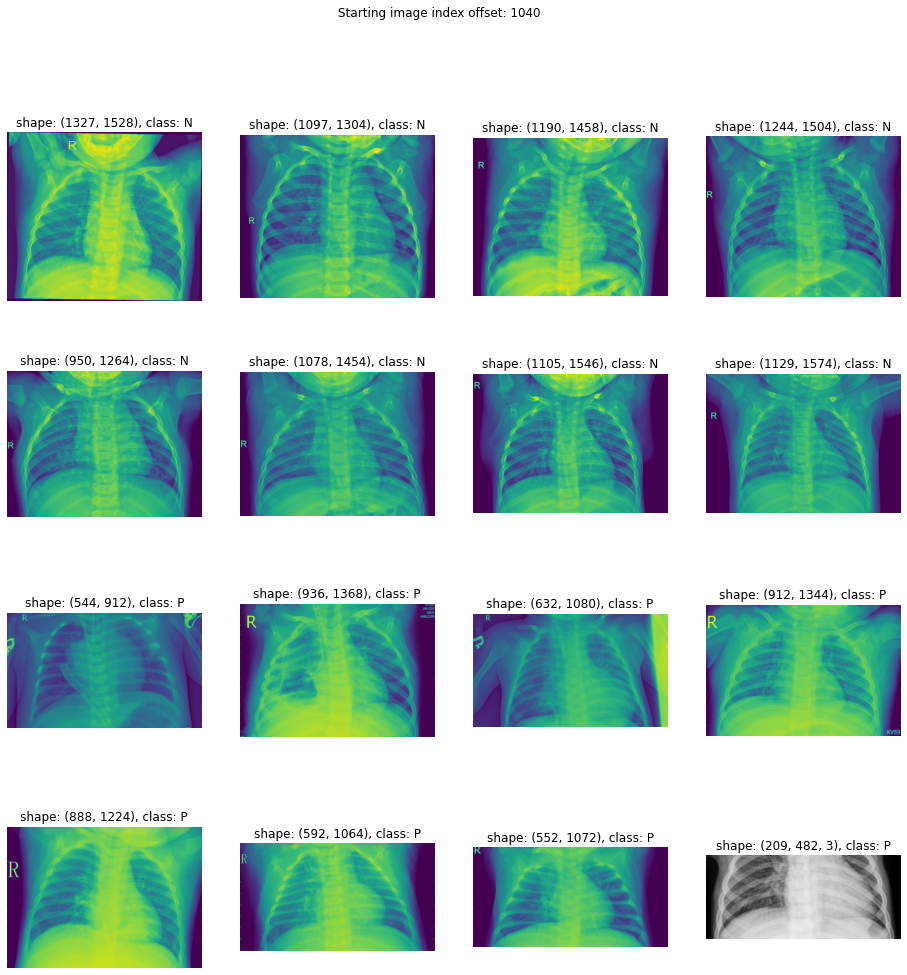

In [6]:
preview_training_images(img_idx_offset=1040)

## Get a feel for the range of all image shapes

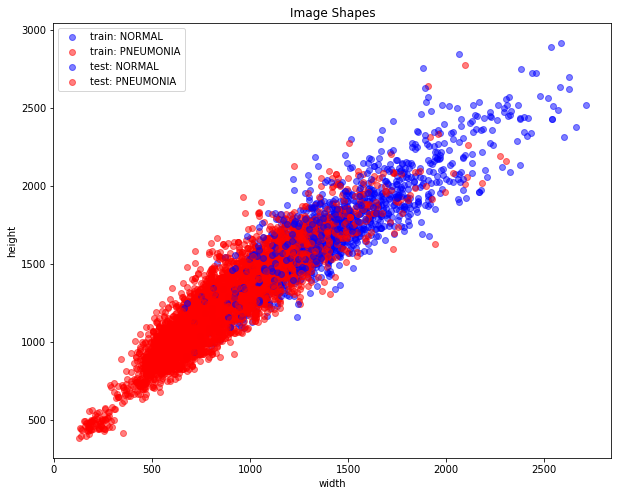

mean shape: (974, 1328)

smallest: ((127, 384), './CellData/chest_xray/train/PNEUMONIA/VIRUS-355597-0002.jpeg')


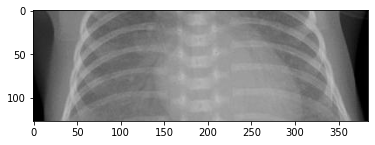


biggest: ((2583, 2916), './CellData/chest_xray/train/NORMAL/NORMAL-9990348-0001.jpeg')


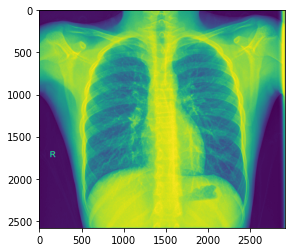

In [7]:
fig = plt.figure(figsize=(10,8))
plt.title('Image Shapes')
plt.xlabel('width')
plt.ylabel('height')
smallest = None
biggest = None
W_all = []
H_all = []
for i, t_image_paths in enumerate([(train_normal_image_paths, train_pneumonia_image_paths), (test_normal_image_paths, test_pneumonia_image_paths)]):
  for j, img_paths in enumerate(t_image_paths):
    W = []
    H = []
    for img_path in img_paths:
      try:
        im = Image.open(img_path)
        im_as_array = np.array(im)
        w = im_as_array.shape[0]
        W.append(w)
        W_all.append(w)
        h = im_as_array.shape[1]
        H.append(h)
        H_all.append(h)
        n_pixels = w*h
        if smallest == None or n_pixels < smallest[0][0]*smallest[0][1]:
          smallest = ((w,h), img_path)
        if biggest == None or n_pixels > biggest[0][0]*biggest[0][1]:
          biggest = ((w,h), img_path)
      except:
        pass
    plt.scatter(
        W, 
        H, 
        c='blue' if j==0 else 'red', 
        alpha=0.5, 
        label=f"{'train' if i==0 else 'test'}: NORMAL" if j==0 else f"{'train' if i==0 else 'test'}: PNEUMONIA"
    )
plt.legend()
plt.show()

mean_shape = (int(np.mean(W_all)), int(np.mean(H_all)))
print(f"mean shape: ({mean_shape[0]}, {mean_shape[1]})")

print(f"\nsmallest: {smallest}")
img = mpimg.imread(smallest[1])
plt.imshow(img);
plt.show()

print(f"\nbiggest: {biggest}")
img = mpimg.imread(biggest[1])
plt.imshow(img);
plt.show()

# Create datasets from images

## First we will augment training images with `ImageDataGenerator`

New (augmented) training images will be created from existing ones, via the following image transformations:
- rotation
- horizontal translation
- vertical translation
- shearing
- zooming
- flipping horizontally (along the vertical axis)

In [8]:
import shutil
from tensorflow.keras.preprocessing.image import ImageDataGenerator

VAL_BATCH_SIZE = TRAIN_BATCH_SIZE = BATCH_SIZE

train_imgdatagen_aug_dir = os.path.join(images_root, 'train-aug')
train_normal_imgdatagen_aug_dir = os.path.join(train_imgdatagen_aug_dir, 'NORMAL')
train_pneumonia_imgdatagen_aug_dir = os.path.join(train_imgdatagen_aug_dir, 'PNEUMONIA')
train_aug_dirs_exist = os.path.isdir(train_imgdatagen_aug_dir) \
  and os.path.isdir(train_normal_imgdatagen_aug_dir) \
  and os.path.isdir(train_pneumonia_imgdatagen_aug_dir) \
  and len(os.listdir(train_normal_imgdatagen_aug_dir))>0 \
  and len(os.listdir(train_pneumonia_imgdatagen_aug_dir))>0
CREATE_TRAIN_AUG_IMAGES = not train_aug_dirs_exist or TRAINING_AUGMENTATION_FORCE_OVERWRITE

if CREATE_TRAIN_AUG_IMAGES:
  # All images will be rescaled by 1./255 but, most importantly, we will use data augmentation to simulate a bigger training set
  train_aug_imgdatagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
  )

  try:
    try:
      shutil.rmtree(train_imgdatagen_aug_dir)
    except:
      pass
    os.mkdir(train_imgdatagen_aug_dir)
    os.mkdir(train_normal_imgdatagen_aug_dir)
    os.mkdir(train_pneumonia_imgdatagen_aug_dir)
  except OSError as e:
      pass

In [9]:
import random

def create_augmented_images(src_train_img_paths, aug_ratio, dest_dir, fname_prefix):
  shuffled_src_train_img_paths = random.sample(src_train_img_paths, len(src_train_img_paths))
  train_aug_src_train_img_paths = shuffled_src_train_img_paths[0:int(len(src_train_img_paths)*aug_ratio)]
  for i, train_image_path in enumerate(train_aug_src_train_img_paths):
    img = np.expand_dims(tf.keras.preprocessing.image.load_img(train_image_path), 0)
    train_aug_imgdatagen.flow(
      img,
      save_to_dir=dest_dir,
      save_prefix=fname_prefix,
      save_format='jpeg'  
    ).next()

if CREATE_TRAIN_AUG_IMAGES:
  create_augmented_images(
      train_normal_image_paths, 
      aug_ratio=TRAINING_AUGMENTATION_RATIO, 
      dest_dir=train_normal_imgdatagen_aug_dir, 
      fname_prefix='NORMAL-AUG'
  )
  print(f"{len(os.listdir(train_normal_imgdatagen_aug_dir))} augmented training images created in {train_normal_imgdatagen_aug_dir}")
  create_augmented_images(
      train_pneumonia_image_paths, 
      aug_ratio=TRAINING_AUGMENTATION_RATIO, 
      dest_dir=train_pneumonia_imgdatagen_aug_dir, 
      fname_prefix='PNEUMONIA-AUG'
  )
  print(f"{len(os.listdir(train_pneumonia_imgdatagen_aug_dir))} augmented training images created in {train_pneumonia_imgdatagen_aug_dir}")

## Run the following cell for an overview of some of augmented training images

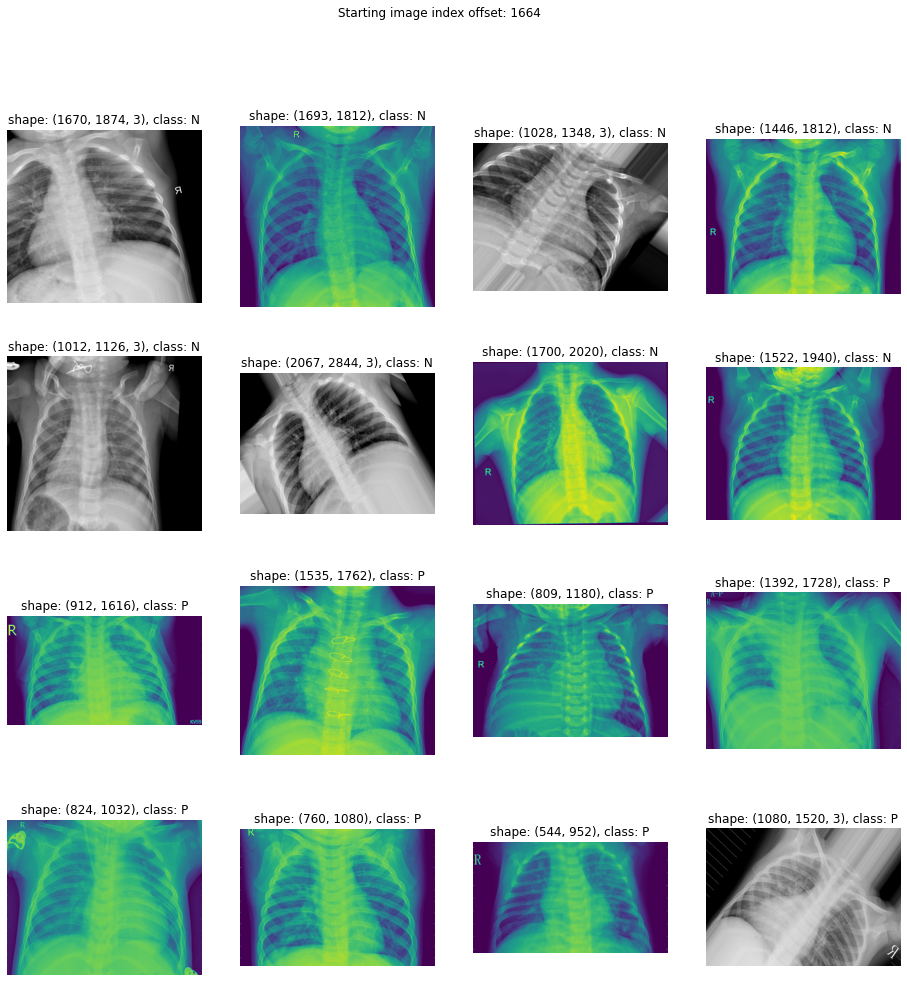

In [10]:
preview_training_images(
    train_normal_dir=train_normal_imgdatagen_aug_dir,
    train_pneumonia_dir=train_pneumonia_imgdatagen_aug_dir,
    img_idx_offset=None
)

## Copy source training images into the augmented training images directory

In [11]:
# copy source training images into train-aug
from shutil import copyfile

if CREATE_TRAIN_AUG_IMAGES:
  for fn in train_normal_fnames:
      copyfile(os.path.join(train_normal_dir, fn), os.path.join(train_normal_imgdatagen_aug_dir, fn))
  print(f"{len(os.listdir(train_normal_imgdatagen_aug_dir))} augmented training images found in {train_normal_imgdatagen_aug_dir}")
  for fn in train_pneumonia_fnames:
      copyfile(os.path.join(train_pneumonia_dir, fn), os.path.join(train_pneumonia_imgdatagen_aug_dir, fn))
  print(f"{len(os.listdir(train_pneumonia_imgdatagen_aug_dir))} augmented training images found in {train_pneumonia_imgdatagen_aug_dir}")

In [12]:
train_aug_normal_fnames = list_images(train_normal_imgdatagen_aug_dir)
n_train_aug_normal = len(train_aug_normal_fnames)
train_aug_pneumonia_fnames = list_images(train_pneumonia_imgdatagen_aug_dir)
n_train_aug_pneumonia = len(train_aug_pneumonia_fnames)
n_train_aug = n_train_aug_normal + n_train_aug_pneumonia
n_train_aug_normal_ratio = n_train_aug_normal/n_train_aug
n_train_aug_pneumonia_ratio = n_train_aug_pneumonia/n_train_aug
print(f"total augmented training images: {n_train_aug}")
print(f'\tNORMAL: {n_train_aug_normal} ({round(n_train_aug_normal_ratio, 2)})')
print(f'\tPNEUMONIA: {n_train_aug_pneumonia} ({round(n_train_aug_pneumonia_ratio, 2)})')

train_aug_normal_image_paths = [os.path.join(train_normal_imgdatagen_aug_dir, fname) for fname in train_aug_normal_fnames]
train_aug_pneumonia_image_paths = [os.path.join(train_pneumonia_imgdatagen_aug_dir, fname) for fname in train_aug_pneumonia_fnames]

total augmented training images: 6485
	NORMAL: 1679 (0.26)
	PNEUMONIA: 4806 (0.74)


# Build the Convolutional Neural Network

The following functions simplify/condense the code-representation of the CNN's architecture.

In [13]:
from tensorflow.keras.layers import Conv2D, SeparableConv2D, BatchNormalization, MaxPooling2D, Dropout, Flatten, Dense

def layer_conv2D(
    inputs, 
    n_filters,  
    conv_kernel_size=(3,3),
    activation='relu', 
    same_padding=True, 
    double_conv=False,
    is_separable=False, 
    normalize_batch=False,
    pool=True, 
    dropout_rate=0.0
):
  conv2D_layer_class = SeparableConv2D if is_separable else Conv2D

  # always present
  output = conv2D_layer_class(
      filters=n_filters, 
      kernel_size=conv_kernel_size, 
      padding='same' if same_padding else 'valid', 
      activation=activation
  )(inputs)
  if double_conv:
    output = conv2D_layer_class(
        filters=n_filters, 
        kernel_size=conv_kernel_size, 
        padding='same' if same_padding else 'valid', 
        activation=activation
    )(output)

  if normalize_batch:
    output = BatchNormalization()(output)

  if pool:
    output = MaxPooling2D((2,2))(output)

  assert(dropout_rate>=0 and dropout_rate<1)
  if dropout_rate > 0:
    output = Dropout(dropout_rate)(output)

  return output


def layer_fc(inputs, n_units, activation='relu', dropout_rate=0.0):
  output = Dense(n_units, activation=activation)(inputs)

  assert(dropout_rate>=0 and dropout_rate<1)
  if dropout_rate > 0:
    output = Dropout(dropout_rate)(output)

  return output

The idea is for the CNN to become increasingly discerning with magnification of each subsequent convolution, proceeding from general to specific.

In [14]:
dnn_inputs        = tf.keras.Input                  ((INPUT_SHAPE[0],INPUT_SHAPE[1],3))

#model 1
cnn_layer_output  = layer_conv2D                    (dnn_inputs,          n_filters=8,    conv_kernel_size=(3,3),   normalize_batch=False,  pool=True)
cnn_layer_output  = layer_conv2D                    (cnn_layer_output,    n_filters=16,   conv_kernel_size=(3,3),   normalize_batch=False,  pool=True)
cnn_layer_output  = layer_conv2D                    (cnn_layer_output,    n_filters=32,   conv_kernel_size=(3,3),   normalize_batch=False,  pool=True)
cnn_layer_output  = layer_conv2D                    (cnn_layer_output,    n_filters=64,   conv_kernel_size=(3,3),   normalize_batch=True,   pool=True)
cnn_layer_output  = layer_conv2D                    (cnn_layer_output,    n_filters=128,  conv_kernel_size=(3,3),   normalize_batch=True,   pool=True)
cnn_layer_output  = layer_conv2D                    (cnn_layer_output,    n_filters=256,  conv_kernel_size=(3,3),   normalize_batch=True,   pool=True)
cnn_layer_output  = layer_conv2D                    (cnn_layer_output,    n_filters=512,  conv_kernel_size=(3,3),   normalize_batch=True,   pool=True)
fcnn_inputs       = Flatten()                       (cnn_layer_output)
fcnn_output       = layer_fc                        (fcnn_inputs,         n_units=1024,    dropout_rate=0.2)

dnn_outputs       = Dense(1, activation='sigmoid')  (fcnn_output)

model = tf.keras.Model(inputs=dnn_inputs, outputs=dnn_outputs)

In [15]:
model.compile(
    optimizer=OPTIMIZER,
    loss='binary_crossentropy',
    metrics = [
      'accuracy'
      # , tf.keras.metrics.Precision(name='precision')
      # , tf.keras.metrics.Recall(name='recall')
    ]
)

model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 150, 150, 8)       224       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 16)        1168      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 37, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 18, 32)       

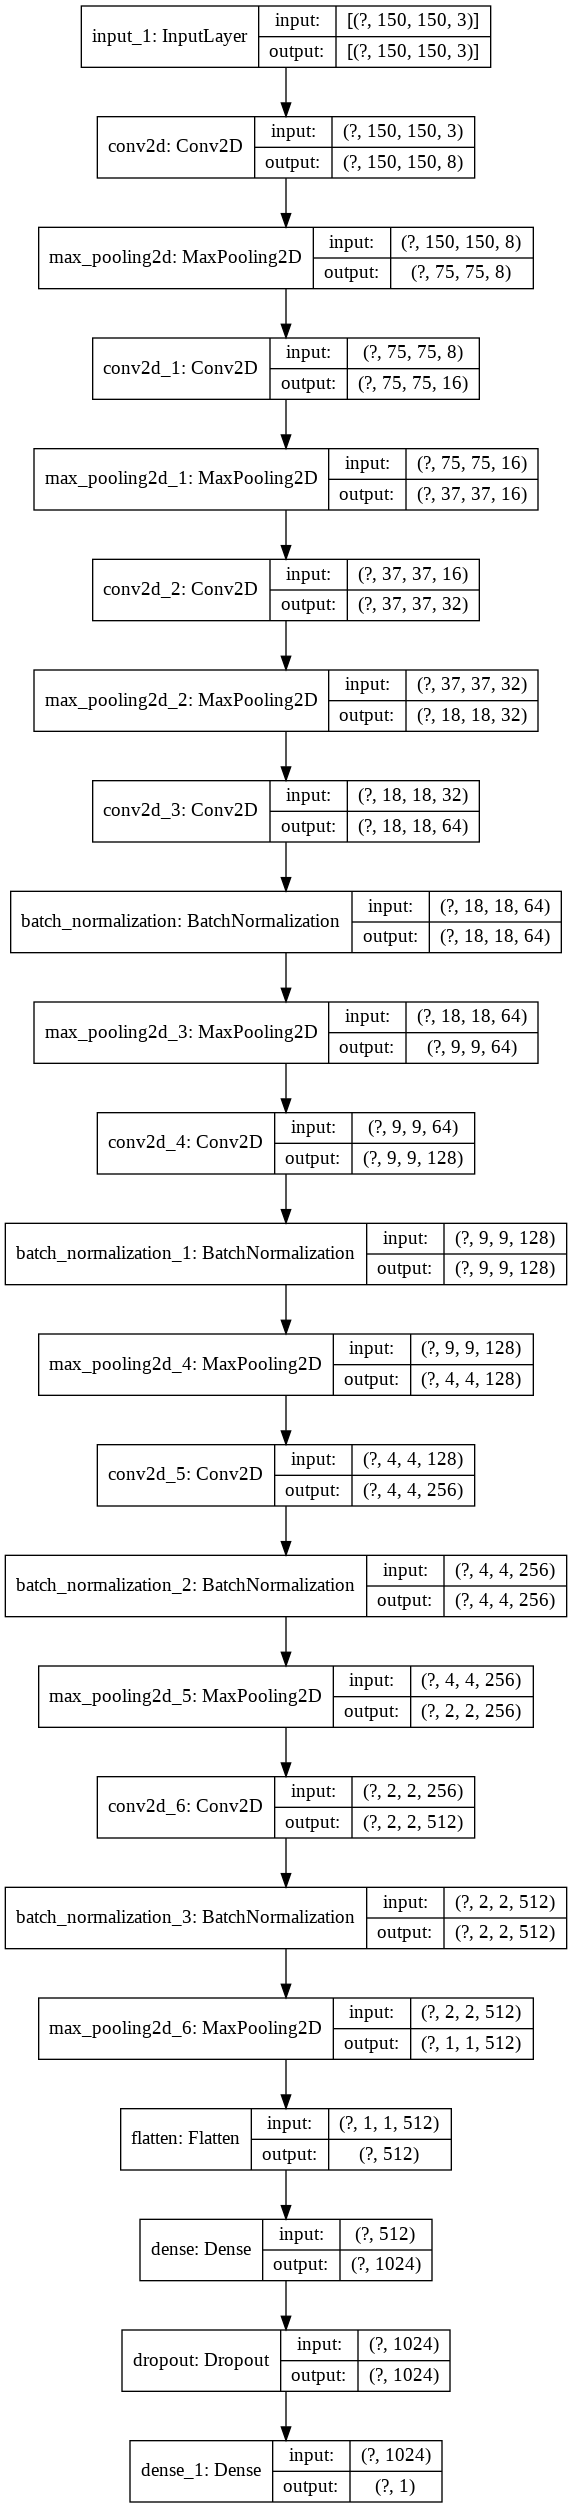

In [16]:
# !git clone https://github.com/gwding/draw_convnet
# import draw_convnet

from keras.utils import plot_model

plot_model(model, show_shapes=True, rankdir='TB', to_file="sc-mod4-cnn.png")

# Consider Class Imbalance

In [17]:
n_classes = 2
weight_normal = (1/n_train_aug_normal_ratio)*(1-VALIDATION_SPLIT)/n_classes
weight_pneumonia = (1/n_train_aug_pneumonia_ratio)*(1-VALIDATION_SPLIT)/n_classes
class_weights = {0: weight_normal, 1: weight_pneumonia}
print('Class 0 (NORMAL, augmented) weight: {:.2f}'.format(weight_normal))
print('Class 1 (PNEUMONIA, augmented) weight: {:.2f}'.format(weight_pneumonia))

Class 0 (NORMAL, augmented) weight: 1.74
Class 1 (PNEUMONIA, augmented) weight: 0.61


In [18]:
from tensorflow.keras.preprocessing import image_dataset_from_directory
# train_imgdatagen = ImageDataGenerator(
#   rescale=1./255,
#   validation_split=VALIDATION_SPLIT
# )    
# train_imgdata_iterator = train_imgdatagen.flow_from_directory(
#     train_imgdatagen_aug_dir,
#     batch_size=TRAIN_BATCH_SIZE, 
#     class_mode='binary',
#     target_size=INPUT_SHAPE,
#     subset='training'
# )
# val_imgdata_iterator = train_imgdatagen.flow_from_directory(
#     train_imgdatagen_aug_dir,
#     batch_size=VAL_BATCH_SIZE,
#     class_mode='binary',
#     target_size=INPUT_SHAPE,
#     subset='validation'
# )

# test_imgdatagen = ImageDataGenerator(rescale = 1.0/255.)
# test_imgdata_iterator = test_imgdatagen.flow_from_directory(
#     test_dir,
#     batch_size=BATCH_SIZE,
#     class_mode='binary',
#     target_size=INPUT_SHAPE
# )

train_ds = image_dataset_from_directory(
    directory=train_imgdatagen_aug_dir, 
    labels='inferred', 
    label_mode='int', 
    color_mode='rgb', 
    batch_size=TRAIN_BATCH_SIZE, 
    image_size=INPUT_SHAPE, 
    shuffle=True, 
    seed=42,
    validation_split=VALIDATION_SPLIT, 
    subset='training'
)

val_ds = image_dataset_from_directory(
    directory=train_imgdatagen_aug_dir, 
    labels='inferred', 
    label_mode='int', 
    color_mode='rgb', 
    batch_size=VAL_BATCH_SIZE, 
    image_size=INPUT_SHAPE, 
    shuffle=True, 
    seed=42,
    validation_split=VALIDATION_SPLIT, 
    subset='validation'
)

Found 6485 files belonging to 2 classes.
Using 5837 files for training.
Found 6485 files belonging to 2 classes.
Using 648 files for validation.


Fit the CNN to the training images using the ImageDataGenerators

We will also stop early if we reach better than 95% accuracy.

In [19]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

class AccuracyThresholdStopper(tf.keras.callbacks.Callback):
  def __init__(self, accuracy_threshold, require_validation=False): # 0 <= accuracy_threshold < 1
    assert(0<=accuracy_threshold and accuracy_threshold<1)
    self.accuracy_threshold = accuracy_threshold
    self.require_validation = require_validation
    self.halting_epoch = -1

  def on_epoch_end(self, epoch, logs={}):
    if logs.get('accuracy') > self.accuracy_threshold:
      if not self.require_validation or logs.get('val_accuracy') > self.accuracy_threshold:
        self.halting_epoch = epoch
        self.model.stop_training = True
        print(f"\nReached {self.accuracy_threshold*100}% accuracy{' (require_validation==True)' if self.require_validation else ''} so canceling training!")

acc_threshold_stopper = AccuracyThresholdStopper(accuracy_threshold=ACCURACY_THRESHOLD, require_validation=True)

history = model.fit(
    # train_imgdata_iterator,
    train_ds,

    epochs=EPOCHS,
    # steps_per_epoch=int(n_train/train_batch_size), # auto-calc if not specified

    # validation_data=val_imgdata_iterator,
    validation_data=val_ds,
    # validation_steps=int(n_test/val_batch_size), # auto-calc if not specified

    class_weight=class_weights,

    callbacks=[
      ModelCheckpoint(filepath='best_val_loss_model.hdf5', monitor='val_loss', save_best_only=True, save_weights_only=False), 
      ModelCheckpoint(filepath='best_val_acc_model.hdf5', monitor='val_accuracy', save_best_only=True, save_weights_only=False),

      # ReduceLROnPlateau(monitor='val_loss', factor=(1/lr_deceleration), patience=2, verbose=2, mode='min'), # increasing lr this way is not supported
      ReduceLROnPlateau(monitor='val_loss', factor=LR_DECELERATION, patience=2, verbose=2, mode='max'),

      acc_threshold_stopper
      # , EarlyStopping(monitor='loss', patience=3) # not particularly useful
    ],

    verbose=1
)

Epoch 1/40
365/365 [==============================] - 37s 103ms/step - loss: 0.2966 - accuracy: 0.8693 - val_loss: 0.1947 - val_accuracy: 0.9321
Epoch 2/40
365/365 [==============================] - 37s 102ms/step - loss: 0.1584 - accuracy: 0.9339 - val_loss: 0.2125 - val_accuracy: 0.9151
Epoch 3/40
365/365 [==============================] - 38s 104ms/step - loss: 0.1308 - accuracy: 0.9399 - val_loss: 0.1608 - val_accuracy: 0.9444
Epoch 4/40
365/365 [==============================] - 37s 103ms/step - loss: 0.1104 - accuracy: 0.9491 - val_loss: 0.3395 - val_accuracy: 0.8858
Epoch 5/40
365/365 [==============================] - 37s 103ms/step - loss: 0.1084 - accuracy: 0.9532 - val_loss: 0.1455 - val_accuracy: 0.9336
Epoch 6/40
365/365 [==============================] - ETA: 0s - loss: 0.1123 - accuracy: 0.9500
Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.000800000037997961.
365/365 [==============================] - 37s 101ms/step - loss: 0.1123 - accuracy: 0.9500 - val_lo

In [20]:
# now select the best one based on val_accuracy
if acc_threshold_stopper.halting_epoch == -1 or acc_threshold_stopper.halting_epoch == EPOCHS:
  model = tf.keras.models.load_model('best_val_acc_model.hdf5')

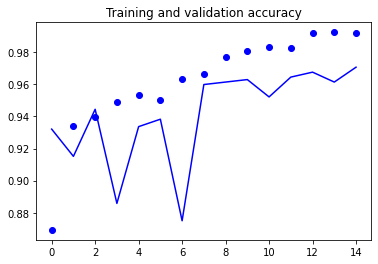

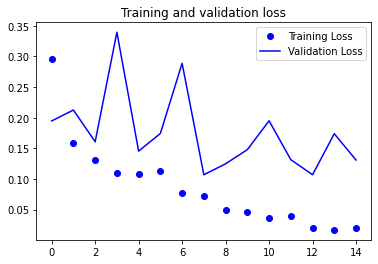

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.figure()
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')

plt.legend()
plt.show()

In [22]:
test_ds = image_dataset_from_directory(
    directory=test_dir, 
    labels='inferred', 
    label_mode='int', 
    color_mode='rgb', 
    batch_size=BATCH_SIZE, 
    image_size=INPUT_SHAPE,
    shuffle=False   # this is imperative!
)
class_names = test_ds.class_names

test_labels = []
for _, labels in test_ds.take(-1):
    numpy_labels = labels.numpy()
    test_labels.extend(numpy_labels)
test_labels = np.array(test_labels)

preds = [a[0] for a in (model.predict(x=test_ds,verbose=0) > 0.5).astype(int)]

Found 624 files belonging to 2 classes.


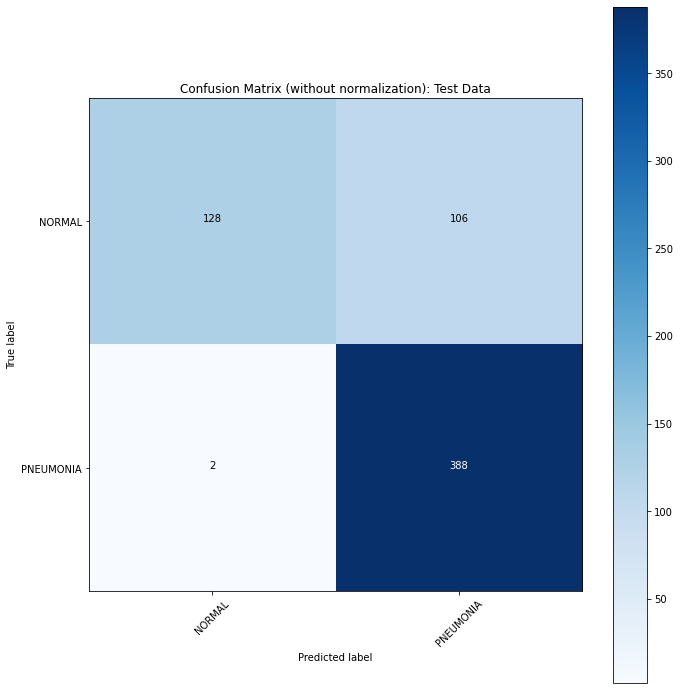


              precision    recall  f1-score   support

      NORMAL       0.98      0.55      0.70       234
   PNEUMONIA       0.79      0.99      0.88       390

    accuracy                           0.83       624
   macro avg       0.89      0.77      0.79       624
weighted avg       0.86      0.83      0.81       624



In [23]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

s_test_labels = list(map(lambda il: class_names[il], test_labels))
s_pred_labels = list(map(lambda il: class_names[il], preds))
cnf_matrix = confusion_matrix(s_test_labels, s_pred_labels, labels=class_names)
np.set_printoptions(precision=2)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion Matrix (without normalization): Test Data')
plt.show();

print()
print(classification_report(s_test_labels, s_pred_labels, target_names=class_names))

# To conclude, visually display an example of how convolutions in the model select features from images

This code is from github.com/lmoroney/dlaicourse/blob/master/Course%202%20-%20Part%202%20-%20Lesson%202%20-%20Notebook.ipynb#scrollTo=-5tES8rXFjux

./CellData/chest_xray/train-aug/PNEUMONIA/BACTERIA-5285130-0005.jpeg


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide


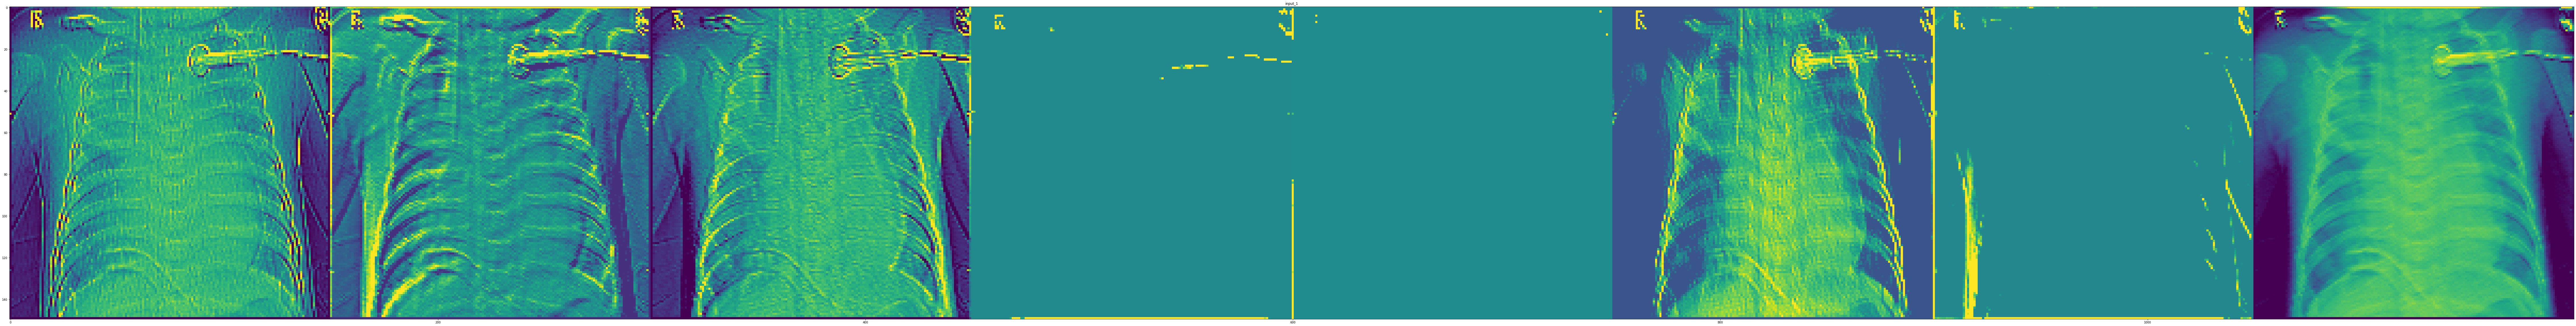

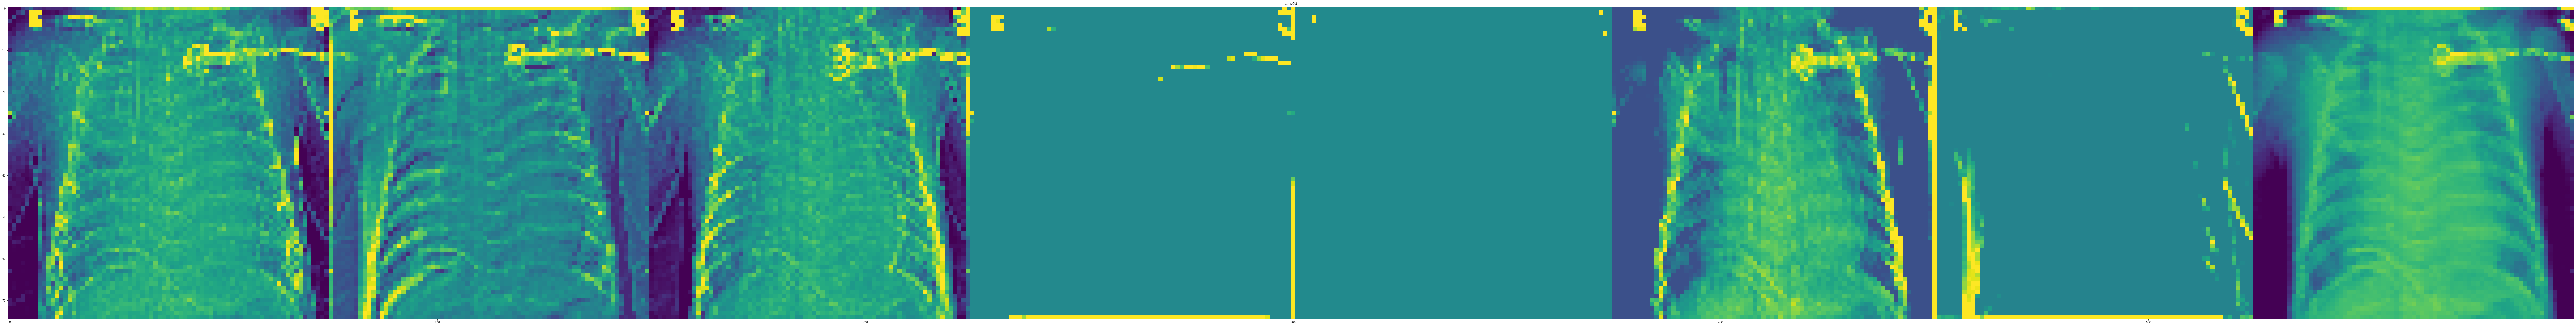

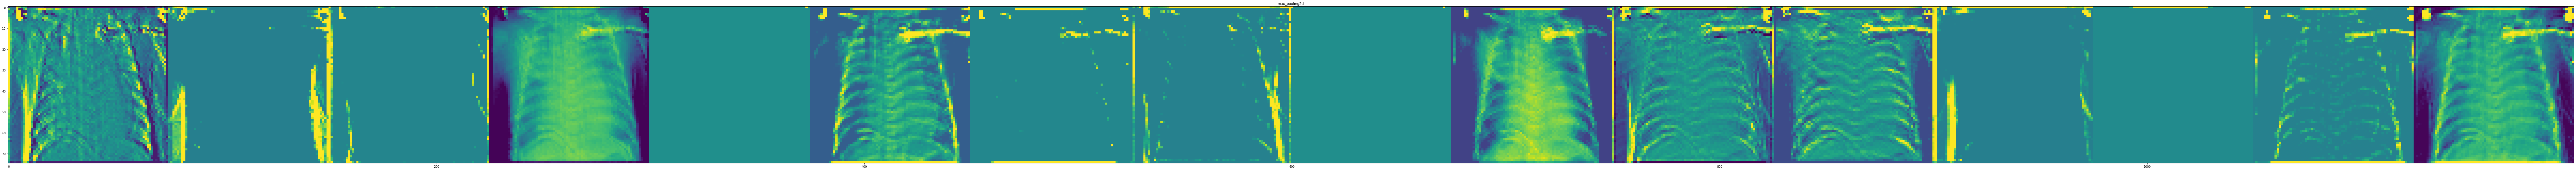

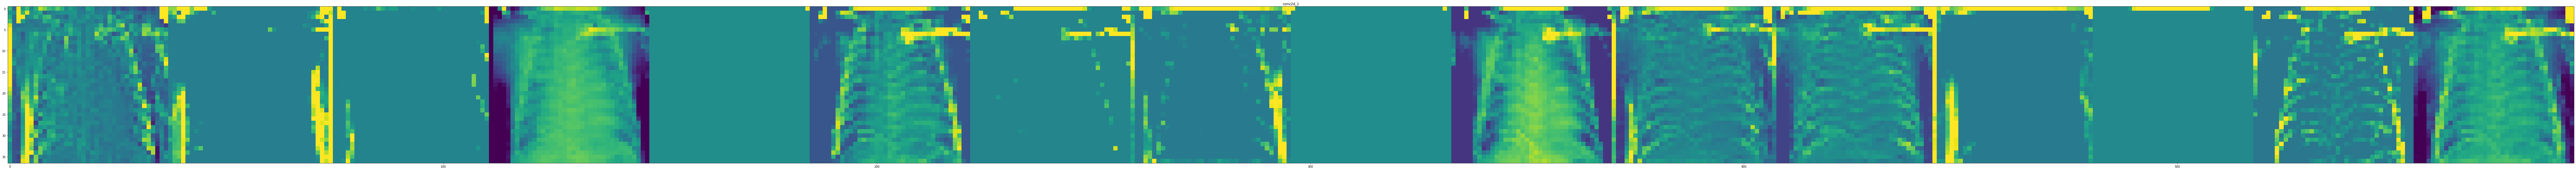

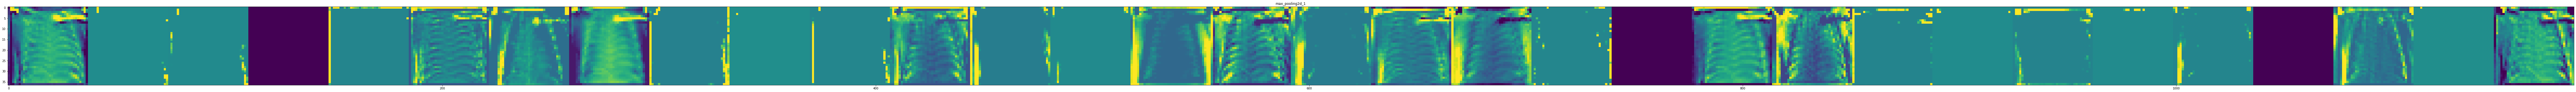

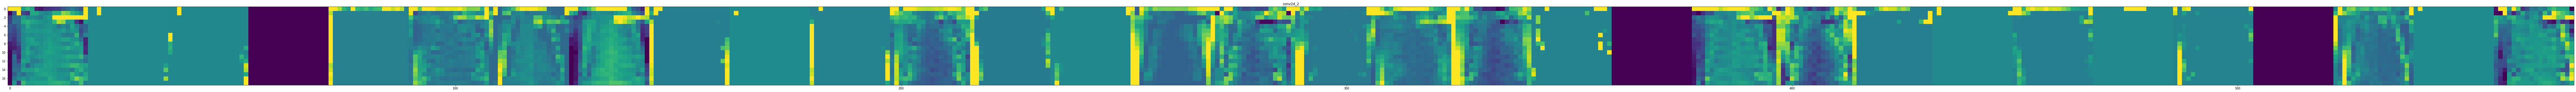

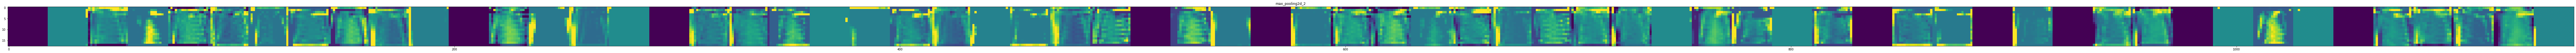

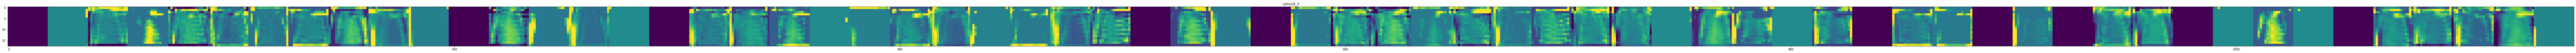

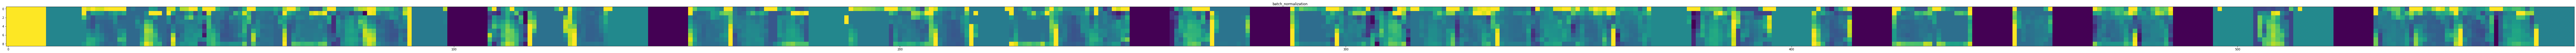

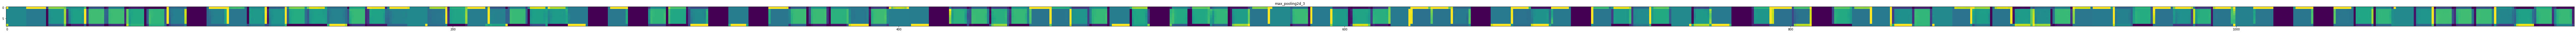

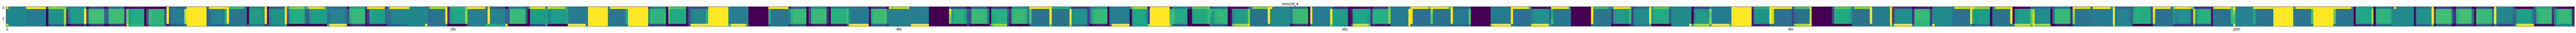

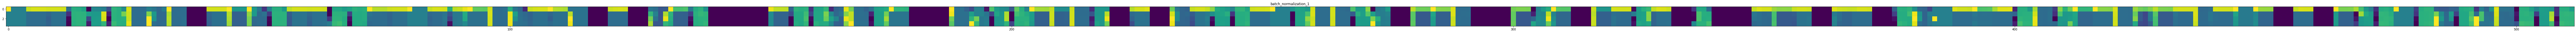

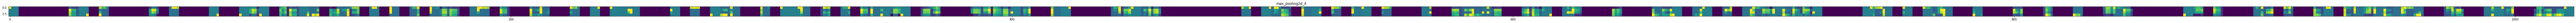

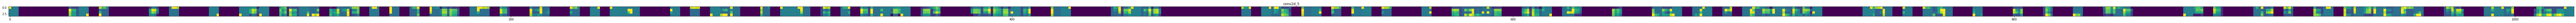

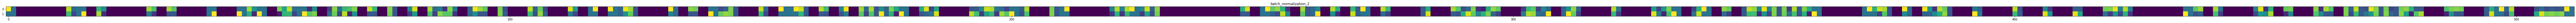

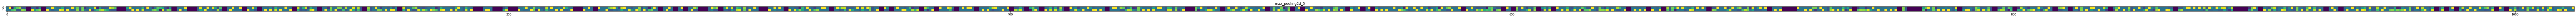

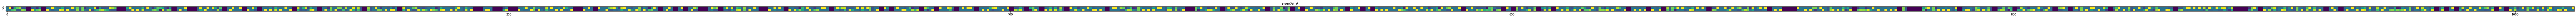

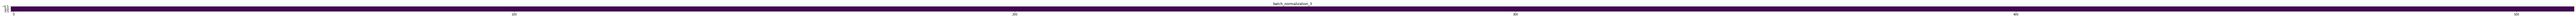

In [24]:
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# Let's define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model after
# the first.
successive_outputs = [layer.output for layer in model.layers[1:]]

#visualization_model = Model(img_input, successive_outputs)
visualization_model = tf.keras.models.Model(inputs=model.input, outputs=successive_outputs)

normal_img_files = [os.path.join(train_normal_imgdatagen_aug_dir, f) for f in train_aug_normal_fnames]
pneumonia_img_files = [os.path.join(train_pneumonia_imgdatagen_aug_dir, f) for f in train_aug_pneumonia_fnames]

img_path = random.choice(normal_img_files + pneumonia_img_files)
print(f"{img_path}")
img = load_img(img_path, target_size=INPUT_SHAPE)  # this is a PIL image

x   = img_to_array(img)                           # Numpy array with shape (150, 150, 3)
x   = x.reshape((1,) + x.shape)                   # Numpy array with shape (1, 150, 150, 3)

# Rescale by 1/255
x /= 255.0

# Let's run our image through our network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers]

# -----------------------------------------------------------------------
# Now let's display our representations
# -----------------------------------------------------------------------
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  
  if len(feature_map.shape) == 4:
    
    #-------------------------------------------
    # Just do this for the conv / maxpool layers, not the fully-connected layers
    #-------------------------------------------
    n_features = feature_map.shape[-1]  # number of features in the feature map
    size       = feature_map.shape[ 1]  # feature map shape (1, size, size, n_features)
    
    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))
    
    #-------------------------------------------------
    # Postprocess the feature to be visually palatable
    #-------------------------------------------------
    for i in range(n_features):
      x  = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std ()
      x *=  64
      x += 128
      x  = np.clip(x, 0, 255).astype('uint8')
      display_grid[:, i * size : (i + 1) * size] = x # Tile each filter into a horizontal grid

    #-----------------
    # Display the grid
    #-----------------

    factor = 8
    scale = (factor*20.) / n_features
    plt.figure( figsize=(scale * n_features, scale) )
    plt.title ( layer_name )
    plt.grid  ( False )
    plt.imshow( display_grid, aspect='auto', cmap='viridis' )